### Notebook Summary

In this notebook, we train a classifier to distinguish whether a pair of new articles, in the sense of real-world events, falls into one of the categories: similar (0), rather similar (1), rather dissimilar (2), and dissimilar (3). Then, we explore the results of training three different models: a neural network, KerasClassifier, logistic regression, and support vector machine (SVM), on provided evaluation data. We also use grid searh to tune the classifiers' hyperparameters to optimize the performance, and keep logs of those information. 

# Multi-Classification with Keras

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import time

from keras.layers import Dense
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, multilabel_confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

We first imported the features we extracted in the previous notebooks, and group them into 4 categories.

In [2]:
train_df = pd.read_csv('train/_TRAIN_features_complete_df.csv')
test_df = pd.read_csv('eval/_EVAL_features_complete_df.csv')
all_df = pd.concat([train_df,test_df])

In [3]:
# Change 'overall' label to 0..3
# 0 being most similar and 3 being not similar

# Train data
for idx,row in train_df.iterrows():
    overall = row['overall']
    train_df.at[idx,'overall'] = overall-1

# Test Data
for idx,row in test_df.iterrows():
    overall = row['overall']
    test_df.at[idx,'overall'] = overall-1

In [4]:
# Check training data labels
print('Check training data label imbalance:')
print(train_df.groupby('overall').size(),'\n')

Check training data label imbalance:
overall
0    497
1    529
2    581
3    978
dtype: int64 



As we see in the training set, there are almost twice as many entries provided for the dissimilar group, which could likely sway the model to 'guess' 3 more often as the possibility that a pair is dissimilar is much higher. But before balancing out the data, we'd like to explore how the models perform on imbalanced data to see if our assumption stands. 

# Training with Imbalanced Data

we first randomly picked some hyperparameters to fit and see how well the Kerasclassifier model predicts.

In [7]:
# Imbalanced training data
target_column = ['overall']
predictors = list(set(list(train_df.drop(['pair_id'], axis=1).columns))-set(target_column))

X_train = train_df[predictors].values
y_train = train_df[target_column].values
X_test = test_df[predictors].values
y_test = test_df[target_column].values

X_train, y_train = shuffle(X_train, y_train, random_state=0)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(y_train)
dummy_y_test = np_utils.to_categorical(y_test)

In [8]:
# Imbalanced training data shape : 2585
# Balanced training data shape : 1988

print(X_train.shape); print(X_test.shape)
print(dummy_y_train.shape); print(dummy_y_test.shape)

(2585, 5)
(2773, 5)
(2585, 4)
(2773, 4)


So we create a KerasClassifier:

In [9]:
# Initialize model with random hyperparameter
hidden_size = 8
epoch = 100
input_size = X_train.shape[1]
output_size = dummy_y_train.shape[1]
learning_rate = 0.01
batch_size = 5
kfold = 5


def baseline_model():
    model = Sequential()
    model.add(Dense(hidden_size, input_dim=input_size, activation='relu'))
    model.add(Dense(output_size, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Create a KerasClassfier
estimator = KerasClassifier(build_fn=baseline_model, epochs=epoch, batch_size=batch_size, verbose=0)

# Number of folds
kfold = KFold(n_splits=kfold, shuffle=True)

And using the training data itself to cross validate to see how the model perform:

In [17]:
start = time.time()
results = cross_val_score(estimator, X_train, dummy_y_train, cv=kfold)

print('Time(s) used:',time.time() - start)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Time(s) used: 218.81608629226685
Baseline: 58.22% (1.06%)


As we can see, even tested using train, the result is not quite ideal (58%), so we can assume that when fed the unseen evaluation data, the result could be even lower:

In [18]:
# Fit train data
train_result = estimator.fit(X_train, dummy_y_train, verbose=1)

Epoch 1/100
517/517 [==============================] - 1s 1ms/step - loss: 1.0924 - accuracy: 0.5048
Epoch 2/100
517/517 [==============================] - 1s 2ms/step - loss: 0.9816 - accuracy: 0.5609
Epoch 3/100
517/517 [==============================] - 1s 2ms/step - loss: 0.9815 - accuracy: 0.5602
Epoch 4/100
517/517 [==============================] - 1s 2ms/step - loss: 0.9796 - accuracy: 0.5590
Epoch 5/100
517/517 [==============================] - 1s 1ms/step - loss: 0.9786 - accuracy: 0.5663
Epoch 6/100
517/517 [==============================] - 1s 1ms/step - loss: 0.9749 - accuracy: 0.5594
Epoch 7/100
517/517 [==============================] - 1s 1ms/step - loss: 0.9773 - accuracy: 0.5663
Epoch 8/100
517/517 [==============================] - 1s 2ms/step - loss: 0.9739 - accuracy: 0.5710
Epoch 9/100
517/517 [==============================] - 1s 2ms/step - loss: 0.9764 - accuracy: 0.5621
Epoch 10/100
517/517 [==============================] - 1s 2ms/step - loss: 0.9716 - accura

In [19]:
# Make prediction and get accuracy
y_pred = estimator.predict(X_test)
print('Accuracy on test data:',accuracy_score(y_test, y_pred)*100,'%')
print(classification_report(y_test, y_pred))

Accuracy on test data: 52.54237288135594 %
              precision    recall  f1-score   support

           0       0.57      0.80      0.66       736
           1       0.36      0.23      0.28       652
           2       0.38      0.28      0.32       584
           3       0.63      0.69      0.66       801

    accuracy                           0.53      2773
   macro avg       0.48      0.50      0.48      2773
weighted avg       0.50      0.53      0.50      2773



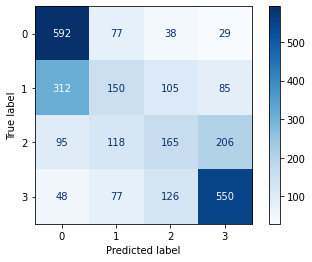

In [20]:
# Display confusion matrix
cm = confusion_matrix(list(y_test), list(y_pred))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

That was fitting using one set of chosen hyperparameters, we actually did a lot of manual tuning before hand to select the previous hyperparameters, but the result was too messy so we decided to switch to GridSearch for a much cleaner tuning.



https://towardsdatascience.com/are-you-using-the-scikit-learn-wrapper-in-your-keras-deep-learning-model-a3005696ff38
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

### GridSearch for Optimal Hyperparameters (KerasClassifier):

In this section, we are using GridSearch and a list of the following hyperparameters we narrowed down from the above mentioned previous manual tuning to find the optimal set to fit the model:
- activation function
- optimizer
- number of epochs
- batch size
- learning rate
- neurons (hidden nodes)

In [6]:
def create_model_grid(neurons = 5 , activation = 'relu', learning_rate = '0.001', optimizer='adam',):
    # Create model
    model = Sequential()
    
    # Activation functions
    if activation=='relu':
        model.add(Dense(neurons, input_dim=input_size, activation='relu'))
    if activation=='tanh':
        model.add(Dense(neurons, input_dim=input_size, activation='tanh'))
    if activation=='sigmoid':
        model.add(Dense(neurons, input_dim=input_size, activation='sigmoid'))
        
    # Output layer    
    model.add(Dense(output_size, activation='sigmoid'))
    
    # Optimizers
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    if optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate = learning_rate)
    if optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    
    # Compile Model
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])
    
    return model

estimator_grid = KerasClassifier(build_fn=create_model_grid, verbose=0)

In [22]:
# List of hyperparameters to be searched
activation_list = ['tanh','relu']
optimizer_list = ['rmsprop','adam','sgd']
epoch_list = [5,10,20]
batch_list = [10,20,50]
learning_rate_list = [0.001, 0.01, 0.1, 0.2, 0.3]
neurons_list = [8, 16, 32]

In [23]:
# Set up GridSearch
param_grid = dict(activation = activation_list,
                 optimizer = optimizer_list,
                 epochs = epoch_list, 
                  batch_size = batch_list,
                 learning_rate = learning_rate_list,
                 neurons = neurons_list)

# Search with 3 folds (cross_validation)
grid = GridSearchCV(estimator = estimator_grid, param_grid = param_grid, cv=3, verbose=2)

In [24]:
# Training to get the best hyperparameter combination
grid_result = grid.fit(X_train,dummy_y_train)

Fitting 3 folds for each of 810 candidates, totalling 2430 fits
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.9s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.8s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.7s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=adam; total time=   2.1s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.8s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.7s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   1.6s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=sgd; tota

[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   1.8s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   2.2s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   2.2s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   2.3s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   2.1s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   2.4s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=32, optimizer=adam; total time=   2.2s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=32, optimizer=adam; total time=   2.1s
[CV] END activation=tanh, batch_size=10, epochs=5, learnin

[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=adam; total time=   4.2s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=adam; total time=   3.4s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   3.9s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   2.5s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   2.3s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=16, optimizer=rmsprop; total time=   2.6s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=16, optimizer=rmsprop; total time=   3.0s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=16, optimizer=rmsprop; total time=   3.0s
[CV] END activation=tanh, batch_size=10

[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   2.1s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   2.1s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=32, optimizer=adam; total time=   2.1s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=32, optimizer=adam; total time=   2.6s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=32, optimizer=adam; total time=   2.2s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   2.0s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   2.2s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   1.9s
[CV] END activation=tanh, batch_size=10, epochs=10, l

[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   3.0s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=16, optimizer=rmsprop; total time=   3.1s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=16, optimizer=rmsprop; total time=   3.3s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=16, optimizer=rmsprop; total time=   3.4s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=16, optimizer=adam; total time=   3.7s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=16, optimizer=adam; total time=   3.5s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=16, optimizer=adam; total time=   3.3s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=16, optimizer=sgd; total time=   4.0s
[CV] END activation=tanh, batch_si

[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.1, neurons=32, optimizer=adam; total time=   3.6s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   3.4s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   3.1s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   3.2s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   3.4s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   3.9s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   3.3s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.2, neurons=8, optimizer=adam; total time=   3.4s
[CV] END activation=tanh, batch_size=10, epochs=20, le

[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=16, optimizer=adam; total time=   1.2s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=16, optimizer=adam; total time=   0.9s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=16, optimizer=adam; total time=   0.9s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=16, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=16, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=16, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   1.2s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   1.0s
[CV] END activation=tanh, batch_size=20, epoc

[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   1.0s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   1.0s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=adam; total time=   0.9s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=adam; total time=   1.2s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=adam; total time=   0.9s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   0.9s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   1.1s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2,

[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=16, optimizer=sgd; total time=   2.1s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   2.7s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   3.2s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   2.5s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=32, optimizer=adam; total time=   3.0s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=32, optimizer=adam; total time=   2.1s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=32, optimizer=adam; total time=   2.1s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   2.5s
[CV] END activation=tanh, batch_s

[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=8, optimizer=adam; total time=   1.5s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   1.6s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   1.4s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   1.4s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=16, optimizer=rmsprop; total time=   1.9s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=16, optimizer=rmsprop; total time=   1.6s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=16, optimizer=rmsprop; total time=   1.6s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=16, optimizer=adam; total time=   1.8s
[CV] END activation=tanh, batch_size=20, epochs=10, le

[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   3.4s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=32, optimizer=adam; total time=   2.8s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=32, optimizer=adam; total time=   2.7s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=32, optimizer=adam; total time=   2.8s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   2.6s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   2.7s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   3.0s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   3.1s
[CV] END activation=tanh, batch_size=20

[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   2.3s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=16, optimizer=rmsprop; total time=   2.3s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=16, optimizer=rmsprop; total time=   2.1s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=16, optimizer=rmsprop; total time=   2.4s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=16, optimizer=adam; total time=   2.4s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=16, optimizer=adam; total time=   2.2s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=16, optimizer=adam; total time=   2.4s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=16, optimizer=sgd; total time=   2.0s
[CV] END activation=tanh, batch_size=20, epochs=20

[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.001, neurons=32, optimizer=adam; total time=   0.7s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   1.1s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   1.0s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   2.9s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   2.1s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   3.5s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   1.7s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.01, neurons=8, optimizer=adam; total time=   1.2s
[CV] END activation=tanh, batch_size=50, epochs=5,

[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=16, optimizer=adam; total time=   1.5s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=16, optimizer=adam; total time=   1.2s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=16, optimizer=adam; total time=   1.1s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=16, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=16, optimizer=sgd; total time=   0.7s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=16, optimizer=sgd; total time=   0.7s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   1.1s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   1.3s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_r

[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   1.3s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   1.1s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=adam; total time=   1.3s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=adam; total time=   0.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=adam; total time=   0.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=10, l

[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=16, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   0.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   0.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   1.3s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=32, optimizer=adam; total time=   1.1s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=32, optimizer=adam; total time=   0.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=32, optimizer=adam; total time=   0.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=1

[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=8, optimizer=adam; total time=   1.1s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   1.0s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   1.2s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   1.3s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=16, optimizer=rmsprop; total time=   1.2s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=16, optimizer=rmsprop; total time=   1.3s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=16, optimizer=rmsprop; total time=   1.5s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=16, optimizer=adam; total time=   1.2s
[CV] END activation=tanh, batch_size=50, epoch

[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=32, optimizer=adam; total time=   1.4s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=32, optimizer=adam; total time=   1.2s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=32, optimizer=adam; total time=   1.2s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   1.4s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   1.2s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   1.1s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   1.2s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   1.5s
[CV] END activation=tanh, batch_size=50, epochs=20, lea

[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=16, optimizer=rmsprop; total time=   1.5s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=16, optimizer=rmsprop; total time=   1.4s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=16, optimizer=adam; total time=   1.6s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=16, optimizer=adam; total time=   1.3s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=16, optimizer=adam; total time=   1.3s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=16, optimizer=sgd; total time=   1.2s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=16, optimizer=sgd; total time=   1.2s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=16, optimizer=sgd; total time=   1.2s
[CV] END activation=relu, batch_size=10, epochs=5, le

[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   1.2s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   1.4s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   1.4s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   1.4s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=adam; total time=   1.6s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=adam; total time=   1.6s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=adam; total time=   1.4s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   1.2s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate

[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=16, optimizer=adam; total time=   2.0s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=16, optimizer=sgd; total time=   1.8s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=16, optimizer=sgd; total time=   1.9s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=16, optimizer=sgd; total time=   2.2s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   2.0s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   2.2s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   2.4s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=32, optimizer=adam; total time=   2.0s
[CV] END activation=relu, batch_size=10, e

[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=adam; total time=   1.9s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=adam; total time=   2.1s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=adam; total time=   2.3s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   1.8s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   1.9s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   1.9s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=16, optimizer=rmsprop; total time=   2.3s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=16, optimizer=rmsprop; total time=   2.1s
[CV] END activation=relu, batch_size=10, epochs=10, learnin

[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   3.9s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   3.8s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   3.9s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=32, optimizer=adam; total time=   3.6s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=32, optimizer=adam; total time=   3.6s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=32, optimizer=adam; total time=   3.3s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   3.2s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   3.7s
[CV] END activation=relu, batch_size=10, 

[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   3.2s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   3.2s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=16, optimizer=rmsprop; total time=   3.4s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=16, optimizer=rmsprop; total time=   4.2s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=16, optimizer=rmsprop; total time=   3.5s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=16, optimizer=adam; total time=   3.4s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=16, optimizer=adam; total time=   3.3s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=16, optimizer=adam; total time=   3.6s
[CV] END activation=relu, batch_size=10, epochs=20,

[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=32, optimizer=adam; total time=   0.9s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=32, optimizer=adam; total time=   1.3s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   0.8s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   0.9s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   0.9s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   1.0s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   1.0s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   1.0s
[CV] END activation=relu, batch_size=20, epochs=5, learn

[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=16, optimizer=rmsprop; total time=   1.3s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=16, optimizer=adam; total time=   0.9s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=16, optimizer=adam; total time=   1.0s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=16, optimizer=adam; total time=   1.0s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=16, optimizer=sgd; total time=   1.0s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=16, optimizer=sgd; total time=   1.0s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=16, optimizer=sgd; total time=   1.3s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   1.4s
[CV] END activation=relu, batch_size=20, epochs=5, learning_r

[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   1.6s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   1.3s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   1.3s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   1.4s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=adam; total time=   1.3s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=adam; total time=   1.6s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=adam; total time=   1.8s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   1.2s
[CV] END activation=relu, batch_size=20, epochs=10, lea

[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=16, optimizer=sgd; total time=   1.5s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=16, optimizer=sgd; total time=   1.2s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=16, optimizer=sgd; total time=   1.3s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   1.4s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   1.4s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   1.4s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=32, optimizer=adam; total time=   1.6s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=32, optimizer=adam; total time=   1.3s
[CV] END activation=relu, batch_size=20, epochs=10

[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=adam; total time=   2.4s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=adam; total time=   2.3s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=adam; total time=   2.0s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   1.9s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   1.9s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   1.9s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=16, optimizer=rmsprop; total time=   2.1s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=16, optimizer=rmsprop; total time=   2.7s
[CV] END activation=relu, batch_size=20, epochs=20, learnin

[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   2.0s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   2.1s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=32, optimizer=adam; total time=   2.3s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=32, optimizer=adam; total time=   2.1s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=32, optimizer=adam; total time=   2.0s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   1.8s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   2.1s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   1.9s
[CV] END activation=relu, batch_size=50, epochs=5, le

[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   1.0s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=16, optimizer=rmsprop; total time=   0.8s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=16, optimizer=rmsprop; total time=   0.8s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=16, optimizer=rmsprop; total time=   0.8s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=16, optimizer=adam; total time=   0.7s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=16, optimizer=adam; total time=   0.7s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=16, optimizer=adam; total time=   1.0s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   0.6s
[CV] END activation=relu, batch_size=50, epochs=5, learnin

[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   1.0s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   0.7s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   0.7s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   0.9s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   0.9s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.0s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.1s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=adam; total time=   0.8s
[CV] END activation=relu, batch_size=50, epochs=

[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=16, optimizer=adam; total time=   0.8s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=16, optimizer=adam; total time=   0.9s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=16, optimizer=adam; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   0.8s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   0.9s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   0.8s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   0.9s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   1.0s
[CV] END activation=relu, batch_size=50, epochs=10, l

[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.5s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.4s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   1.1s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   1.1s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   1.1s
[CV] END activation=relu, batch_size=50, epoc

[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   1.1s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   1.1s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.5s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.1s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.1s
[CV] END activation=relu, batch_size=50, epochs=2

And we get the optimal set to be:

In [25]:
# Print Best Result
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.582978 using {'activation': 'relu', 'batch_size': 10, 'epochs': 10, 'learning_rate': 0.01, 'neurons': 16, 'optimizer': 'adam'}


In [26]:
# Details in the traininf results
grid.cv_results_

{'mean_fit_time': array([1.57791336, 1.64604147, 1.45817423, 1.6089646 , 1.74048026,
        1.34062481, 1.72710673, 1.70706924, 1.77508068, 1.65265258,
        1.62461543, 1.37807226, 1.94686715, 1.98011621, 1.7914776 ,
        2.09962201, 1.74349348, 1.89903649, 1.6869626 , 1.75769957,
        1.52279329, 1.8026154 , 1.76320855, 1.73751521, 2.00724332,
        1.80047361, 1.76849802, 1.83514396, 1.94734669, 1.66813151,
        1.91164883, 1.70313025, 1.67124669, 1.88278667, 1.44766378,
        1.5525353 , 1.97493315, 1.61064974, 1.3959295 , 1.81097968,
        1.46403344, 1.55276394, 1.75644445, 1.78262575, 2.78657897,
        3.84792662, 3.28486149, 2.65678247, 2.62361972, 2.44247564,
        2.1349295 , 2.7340072 , 2.91063245, 2.47981445, 3.06817142,
        2.58559696, 2.30333368, 2.70382102, 2.48583738, 2.43422023,
        2.60054517, 2.64943894, 2.2989188 , 2.60595353, 2.14786688,
        1.95095929, 2.13229926, 2.02607989, 2.11690227, 1.96470483,
        2.02963869, 1.87346474,

In [27]:
# Get Hyperparameter listed out and shown as dataframe
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

df = pd.DataFrame(params)
df['Mean'] = means
df['Std'] = stds

df.sort_values('Mean',ascending=False)

,activation,batch_size,epochs,learning_rate,neurons,optimizer,Mean,Std
463,relu,10,10,0.010,16,adam,0.582978,0.004799
511,relu,10,20,0.010,32,adam,0.582201,0.006862
398,tanh,50,20,0.300,8,sgd,0.581435,0.009559
696,relu,50,5,0.100,16,rmsprop,0.580650,0.014467
74,tanh,10,10,0.200,8,sgd,0.578727,0.007539
...,...,...,...,...,...,...,...,...
677,relu,50,5,0.001,8,sgd,0.284375,0.077565
683,relu,50,5,0.001,32,sgd,0.272363,0.042244
272,tanh,50,5,0.001,8,sgd,0.259560,0.069716
178,tanh,20,5,0.300,32,adam,0.248358,0.010966


In [28]:
# Make prediction on test data with the best hyperparameters
y_pred = grid.predict(X_test)

print('Accuracy on test data:',accuracy_score(y_test, y_pred)*100,'%')
print(classification_report(y_test, y_pred))

Accuracy on test data: 51.71294626758024 %
              precision    recall  f1-score   support

           0       0.55      0.80      0.65       736
           1       0.34      0.31      0.33       652
           2       0.37      0.21      0.27       584
           3       0.67      0.65      0.66       801

    accuracy                           0.52      2773
   macro avg       0.48      0.49      0.48      2773
weighted avg       0.50      0.52      0.50      2773



Even though thhe result wasn't ideal, we observed that the 'rather similar' and 'rather dissimilar' categories are the hardest for our model to predict, and to figure out what happened there, we conducted the following research:

In [29]:
# Check how far our model has mis-labeled prediction
pred_correct = 0
miss_1_label = 0
miss_2_label = 0
miss_3_label = 0

for pos,i in enumerate(y_test):
    if i-y_pred[pos] == 0:
        pred_correct +=1
    elif abs(i-y_pred[pos]) == 1:
        miss_1_label +=1
    elif abs(i-y_pred[pos]) == 2:
        miss_2_label +=1
    elif abs(i-y_pred[pos]) == 3:
        miss_3_label +=1

print ('Prediction correct:', pred_correct*100/len(y_test),'%')
print ('Miss by 1 label:', miss_1_label*100/len(y_test),'%')
print ('Miss by 2 labels:', miss_2_label*100/len(y_test),'%')
print ('Miss by 3 labels:', miss_3_label*100/len(y_test),'%')

Prediction correct: 51.712946267580236 %
Miss by 1 label: 34.15073927154706 %
Miss by 2 labels: 11.64803461954562 %
Miss by 3 labels: 2.4882798413270826 %


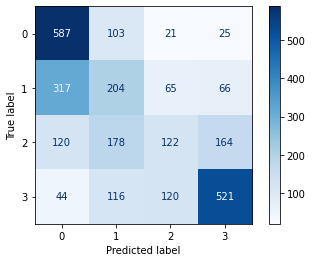

In [30]:
# Display confusion matrix
cm = confusion_matrix(list(y_test), list(y_pred))#,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

Interestingly, the model tends to miscategorize by 1 category quite often. And as the training labels were also provided as an average score (of all the annotators score, so oftentime instead of 1,2,3,4, the labels are floating numbers like 2.333 or 3.6666), meaning even the human annotators are not uniformly agreeing on whether each pair is 'similar' or 'rather similar' (or 'dissimilar' or 'rather dissimilar'), thus making it even harder for the model to predict. That is why in the next notebook, we will group the data into only 2 categories, 1 for similar (including the entries labeled 1.0 to 2.5), and 0 for dissimilar (including the entries labeled 2.5 to 4.0), to see if our assumption is grounded.

In [ ]:
# saving the result for analysis in the final report
df.to_csv('model/NN_multiclass-gridsearch-imbalanced.csv', index=False)

# Training with Balanced Data

Then we repeat the same process but using balanced data:

In [12]:
# We first balance the data by randomly sampling the same amount of them 
balancing = train_df.groupby('overall')
balance_train_df = balancing.apply(lambda x: x.sample(balancing.size().min()))
balance_train_df = balance_train_df.reset_index(drop=True)
print('Check training data label balance:')
print(balance_train_df.groupby('overall').size(),'\n')

Check training data label balance:
overall
0    497
1    497
2    497
3    497
dtype: int64 



In [17]:
# then using the balanced data to create train and test 
target_column = ['overall']
predictors = list(set(list(balance_train_df.drop(['pair_id'], axis=1).columns))-set(target_column))

X_train = balance_train_df[predictors].values
y_train = balance_train_df[target_column].values

X_train, y_train = shuffle(X_train, y_train, random_state=0)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(y_train)
dummy_y_test = np_utils.to_categorical(y_test)

In [18]:
# Imbalanced training data shape : 2585
# Balanced training data shape : 1988

print(X_train.shape); print(X_test.shape)
print(dummy_y_train.shape); print(dummy_y_test.shape)

(1988, 5)
(2773, 5)
(1988, 4)
(2773, 4)


Then create KerasClassifier again for the balanced data:

In [7]:
# Initialize model with random hyperparameter
hidden_size = 8
epoch = 100
input_size = X_train.shape[1]
output_size = dummy_y_train.shape[1]
learning_rate = 0.01
batch_size = 5
kfold = 5

def baseline_model():
    model = Sequential()
    model.add(Dense(hidden_size, input_dim=input_size, activation='relu'))
    model.add(Dense(output_size, activation='sigmoid'))
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# Create a KerasClassfier
estimator = KerasClassifier(build_fn=baseline_model, epochs=epoch, batch_size=batch_size, verbose=0)

# Number of folds
kfold = KFold(n_splits=kfold, shuffle=True)

Cross Validation in Training Data

In [36]:
start = time.time()
results_binn = cross_val_score(estimator, X_train, dummy_y_train, cv=kfold)

print('Time(s) used:',time.time() - start)
print("Baseline: %.2f%% (%.2f%%)" % (results_binn.mean()*100, results_binn.std()*100))

Time(s) used: 110.26552414894104
Baseline: 52.97% (0.68%)


While now that the data is balanced, the performance we get from cross validation is 6% lower (from 58% to 52%), more importantly we want to see how it performs on the test set:

In [37]:
# Fit train data
train_result = estimator.fit(X_train, dummy_y_train, verbose=1)

Epoch 1/100
398/398 [==============================] - 1s 805us/step - loss: 1.2015 - accuracy: 0.4331
Epoch 2/100
398/398 [==============================] - 0s 892us/step - loss: 1.0497 - accuracy: 0.5382
Epoch 3/100
398/398 [==============================] - 0s 870us/step - loss: 1.0430 - accuracy: 0.5277
Epoch 4/100
398/398 [==============================] - 0s 878us/step - loss: 1.0438 - accuracy: 0.5418
Epoch 5/100
398/398 [==============================] - 0s 889us/step - loss: 1.0433 - accuracy: 0.5216
Epoch 6/100
398/398 [==============================] - 0s 906us/step - loss: 1.0388 - accuracy: 0.5327
Epoch 7/100
398/398 [==============================] - 0s 896us/step - loss: 1.0360 - accuracy: 0.5377
Epoch 8/100
398/398 [==============================] - 0s 913us/step - loss: 1.0409 - accuracy: 0.5277
Epoch 9/100
398/398 [==============================] - 0s 886us/step - loss: 1.0322 - accuracy: 0.5372
Epoch 10/100
398/398 [==============================] - 0s 884us/step - l

In [38]:
# Make prediction and get accuracy
y_pred = estimator.predict(X_test)
print('Accuracy on test data:',accuracy_score(y_test, y_pred)*100,'%')
print(classification_report(y_test, y_pred))

Accuracy on test data: 52.181752614496936 %
              precision    recall  f1-score   support

           0       0.60      0.75      0.66       736
           1       0.36      0.33      0.34       652
           2       0.37      0.43      0.40       584
           3       0.74      0.54      0.62       801

    accuracy                           0.52      2773
   macro avg       0.52      0.51      0.51      2773
weighted avg       0.54      0.52      0.52      2773



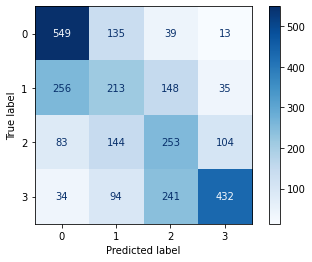

In [39]:
# Display confusion matrix
cm = confusion_matrix(list(y_test), list(y_pred))#,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

Even though the accuracy stays about the same now that the data is balanced (both are roughly 52%), we can see that the model predicts less as 0 (perhaps because the data is now balanced), and more coorrectly predicts for the 'rather similar' and 'rather disimilar' categories. While the performance on 'disimilar' category decreases, the overal f1 score of each category seems to show an improvement.

Then we conduct GridSearch to get the optimal parameters:

In [8]:
def create_model_grid(neurons = 5 , activation = 'relu', learning_rate = '0.001', optimizer='adam',):
    # Create model
    model = Sequential()
    
    # Activation functions
    if activation=='relu':
        model.add(Dense(neurons, input_dim=input_size, activation='relu'))
        #model.add(Dense(neurons, activation='relu'))
    if activation=='tanh':
        model.add(Dense(neurons, input_dim=input_size, activation='tanh'))
        #model.add(Dense(neurons, activation='tanh'))
    if activation=='sigmoid':
        model.add(Dense(neurons, input_dim=input_size, activation='sigmoid'))
        #model.add(Dense(neurons, activation='sigmoid'))
        
    # Output layer    
    model.add(Dense(output_size, activation='sigmoid'))
    
    # Optimizers
    opt = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    if optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate = learning_rate)
    if optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate = learning_rate)
    
    # Compile Model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])
    
    return model

estimator_grid = KerasClassifier(build_fn=create_model_grid, verbose=0)

In [51]:
# List of hyperparameters to be searched
activation_list = ['tanh','relu']
optimizer_list = ['rmsprop','adam','sgd']
epoch_list = [5,10,20]
batch_list = [10,20,50]
learning_rate_list = [0.001, 0.01, 0.1, 0.2, 0.3]
neurons_list = [8, 16, 32]

In [52]:
# Set up GridSearch
param_grid = dict(activation = activation_list,
                 optimizer = optimizer_list,
                 epochs = epoch_list, 
                  batch_size = batch_list,
                 learning_rate = learning_rate_list,
                 neurons = neurons_list)

# Search with 3 folds (cross_validation)
grid = GridSearchCV(estimator = estimator_grid, param_grid = param_grid, cv=3, verbose=2)

In [53]:
# Training to get the best hyperparameter combination
grid_result = grid.fit(X_train,dummy_y_train)

Fitting 3 folds for each of 810 candidates, totalling 2430 fits
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.0s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.0s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.3s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=adam; total time=   0.9s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=adam; total time=   0.9s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.0s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   1.0s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.001, neurons=8, optimizer=sgd; tota

[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   1.4s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   1.0s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   1.3s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   1.4s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   1.3s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   1.3s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.2s
[CV] END activation=tanh, batch_size=10, epochs=5, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.5s
[CV] END activation=tanh, batch_size=10, epochs=5, learnin

[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=adam; total time=   2.2s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=adam; total time=   2.1s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   1.6s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   1.7s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   1.6s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=16, optimizer=rmsprop; total time=   1.8s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=16, optimizer=rmsprop; total time=   1.8s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.001, neurons=16, optimizer=rmsprop; total time=   1.8s
[CV] END activation=tanh, batch_size=10

[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   2.2s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   1.8s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.7s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.7s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.8s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   2.0s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   1.7s
[CV] END activation=tanh, batch_size=10, epochs=10, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   1.6s
[CV] END activation=tanh, batch_size=10, epochs=10, l

[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   3.8s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=16, optimizer=rmsprop; total time=   3.2s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=16, optimizer=rmsprop; total time=   3.1s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=16, optimizer=rmsprop; total time=   3.1s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=16, optimizer=adam; total time=   3.0s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=16, optimizer=adam; total time=   3.8s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=16, optimizer=adam; total time=   2.9s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.001, neurons=16, optimizer=sgd; total time=   2.7s
[CV] END activation=tanh, batch_si

[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.1, neurons=32, optimizer=adam; total time=   3.1s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   2.7s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   2.6s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.1, neurons=32, optimizer=sgd; total time=   3.2s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   2.9s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   3.3s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   3.0s
[CV] END activation=tanh, batch_size=10, epochs=20, learning_rate=0.2, neurons=8, optimizer=adam; total time=   2.9s
[CV] END activation=tanh, batch_size=10, epochs=20, le

[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=16, optimizer=adam; total time=   1.0s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=16, optimizer=adam; total time=   0.9s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=16, optimizer=adam; total time=   1.0s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=16, optimizer=sgd; total time=   0.9s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=16, optimizer=sgd; total time=   1.2s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=16, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   1.0s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   1.1s
[CV] END activation=tanh, batch_size=20, epoc

[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   1.0s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=rmsprop; total time=   1.3s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=adam; total time=   0.9s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=adam; total time=   0.9s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=adam; total time=   0.9s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   1.0s
[CV] END activation=tanh, batch_size=20, epochs=5, learning_rate=0.2,

[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=16, optimizer=sgd; total time=   1.4s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   1.3s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   1.3s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   1.2s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=32, optimizer=adam; total time=   1.2s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=32, optimizer=adam; total time=   1.6s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=32, optimizer=adam; total time=   4.3s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   1.3s
[CV] END activation=tanh, batch_s

[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=8, optimizer=adam; total time=   1.2s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   1.1s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   1.4s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   1.3s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=16, optimizer=rmsprop; total time=   1.3s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=16, optimizer=rmsprop; total time=   1.6s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=16, optimizer=rmsprop; total time=   1.3s
[CV] END activation=tanh, batch_size=20, epochs=10, learning_rate=0.2, neurons=16, optimizer=adam; total time=   1.2s
[CV] END activation=tanh, batch_size=20, epochs=10, le

[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=32, optimizer=rmsprop; total time=   2.4s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=32, optimizer=adam; total time=   2.9s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=32, optimizer=adam; total time=   2.3s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=32, optimizer=adam; total time=   2.4s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   2.6s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   2.0s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   2.1s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   2.6s
[CV] END activation=tanh, batch_size=20

[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=8, optimizer=sgd; total time=   2.4s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=16, optimizer=rmsprop; total time=   2.7s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=16, optimizer=rmsprop; total time=   2.4s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=16, optimizer=rmsprop; total time=   2.4s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=16, optimizer=adam; total time=   2.2s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=16, optimizer=adam; total time=   2.7s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=16, optimizer=adam; total time=   2.1s
[CV] END activation=tanh, batch_size=20, epochs=20, learning_rate=0.2, neurons=16, optimizer=sgd; total time=   2.5s
[CV] END activation=tanh, batch_size=20, epochs=20

[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.001, neurons=32, optimizer=adam; total time=   0.7s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   0.7s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   0.7s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.001, neurons=32, optimizer=sgd; total time=   0.7s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   1.2s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.01, neurons=8, optimizer=adam; total time=   0.7s
[CV] END activation=tanh, batch_size=50, epochs=5,

[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=16, optimizer=adam; total time=   0.7s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=16, optimizer=adam; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=16, optimizer=adam; total time=   0.7s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=16, optimizer=sgd; total time=   0.7s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=16, optimizer=sgd; total time=   1.1s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=16, optimizer=sgd; total time=   0.6s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=5, learning_r

[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   0.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=rmsprop; total time=   0.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=adam; total time=   0.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=adam; total time=   0.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=adam; total time=   1.4s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=10, l

[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=16, optimizer=sgd; total time=   0.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   0.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   0.9s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=32, optimizer=rmsprop; total time=   1.4s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=32, optimizer=adam; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=32, optimizer=adam; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=32, optimizer=adam; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=10, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   0.8s
[CV] END activation=tanh, batch_size=50, epochs=1

[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=8, optimizer=adam; total time=   1.2s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   1.0s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   1.0s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=8, optimizer=sgd; total time=   1.0s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=16, optimizer=rmsprop; total time=   1.5s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=16, optimizer=rmsprop; total time=   1.1s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=16, optimizer=rmsprop; total time=   1.2s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.01, neurons=16, optimizer=adam; total time=   1.1s
[CV] END activation=tanh, batch_size=50, epoch

[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=32, optimizer=adam; total time=   1.1s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=32, optimizer=adam; total time=   1.1s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=32, optimizer=adam; total time=   1.5s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   1.0s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   1.0s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   1.2s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   1.3s
[CV] END activation=tanh, batch_size=50, epochs=20, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   1.2s
[CV] END activation=tanh, batch_size=50, epochs=20, lea

[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=16, optimizer=rmsprop; total time=   1.3s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=16, optimizer=rmsprop; total time=   1.3s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=16, optimizer=adam; total time=   1.5s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=16, optimizer=adam; total time=   1.2s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=16, optimizer=adam; total time=   1.6s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=16, optimizer=sgd; total time=   1.2s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=16, optimizer=sgd; total time=   1.1s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.01, neurons=16, optimizer=sgd; total time=   1.2s
[CV] END activation=relu, batch_size=10, epochs=5, le

[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.2, neurons=32, optimizer=sgd; total time=   1.3s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   1.4s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   1.4s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=rmsprop; total time=   2.1s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=adam; total time=   1.5s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=adam; total time=   1.3s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=adam; total time=   1.3s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   1.2s
[CV] END activation=relu, batch_size=10, epochs=5, learning_rate

[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=16, optimizer=adam; total time=   1.9s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=16, optimizer=sgd; total time=   1.7s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=16, optimizer=sgd; total time=   1.6s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=16, optimizer=sgd; total time=   1.7s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   1.8s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   2.6s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   2.1s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.01, neurons=32, optimizer=adam; total time=   1.8s
[CV] END activation=relu, batch_size=10, e

[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=adam; total time=   2.2s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=adam; total time=   2.0s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=adam; total time=   2.0s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   1.7s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   1.7s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   2.0s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=16, optimizer=rmsprop; total time=   2.2s
[CV] END activation=relu, batch_size=10, epochs=10, learning_rate=0.3, neurons=16, optimizer=rmsprop; total time=   2.1s
[CV] END activation=relu, batch_size=10, epochs=10, learnin

[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   3.3s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   3.3s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=32, optimizer=rmsprop; total time=   2.9s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=32, optimizer=adam; total time=   2.9s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=32, optimizer=adam; total time=   2.9s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=32, optimizer=adam; total time=   3.3s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   3.3s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   3.5s
[CV] END activation=relu, batch_size=10, 

[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   2.7s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=8, optimizer=sgd; total time=   2.9s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=16, optimizer=rmsprop; total time=   3.5s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=16, optimizer=rmsprop; total time=   3.4s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=16, optimizer=rmsprop; total time=   3.5s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=16, optimizer=adam; total time=   3.0s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=16, optimizer=adam; total time=   3.0s
[CV] END activation=relu, batch_size=10, epochs=20, learning_rate=0.3, neurons=16, optimizer=adam; total time=   2.9s
[CV] END activation=relu, batch_size=10, epochs=20,

[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=32, optimizer=adam; total time=   0.9s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=32, optimizer=adam; total time=   0.9s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   0.8s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   0.8s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   0.8s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   1.4s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   0.9s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   1.0s
[CV] END activation=relu, batch_size=20, epochs=5, learn

[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=16, optimizer=rmsprop; total time=   1.0s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=16, optimizer=adam; total time=   1.3s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=16, optimizer=adam; total time=   0.9s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=16, optimizer=adam; total time=   0.9s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=16, optimizer=sgd; total time=   0.8s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=16, optimizer=sgd; total time=   0.8s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=16, optimizer=sgd; total time=   0.8s
[CV] END activation=relu, batch_size=20, epochs=5, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   1.0s
[CV] END activation=relu, batch_size=20, epochs=5, learning_r

[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.01, neurons=32, optimizer=sgd; total time=   1.4s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   1.4s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   1.3s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=rmsprop; total time=   1.7s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=adam; total time=   1.1s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=adam; total time=   1.2s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=adam; total time=   1.2s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   1.1s
[CV] END activation=relu, batch_size=20, epochs=10, lea

[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=16, optimizer=sgd; total time=   1.4s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=16, optimizer=sgd; total time=   1.2s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=16, optimizer=sgd; total time=   1.1s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   1.2s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   1.3s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   1.7s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=32, optimizer=adam; total time=   1.1s
[CV] END activation=relu, batch_size=20, epochs=10, learning_rate=0.3, neurons=32, optimizer=adam; total time=   1.2s
[CV] END activation=relu, batch_size=20, epochs=10

[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=adam; total time=   2.2s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=adam; total time=   2.1s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=adam; total time=   1.8s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   1.7s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   1.6s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   1.6s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=16, optimizer=rmsprop; total time=   1.8s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.1, neurons=16, optimizer=rmsprop; total time=   1.8s
[CV] END activation=relu, batch_size=20, epochs=20, learnin

[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   1.8s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=32, optimizer=rmsprop; total time=   2.0s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=32, optimizer=adam; total time=   2.1s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=32, optimizer=adam; total time=   2.3s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=32, optimizer=adam; total time=   1.7s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   1.6s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   1.6s
[CV] END activation=relu, batch_size=20, epochs=20, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   1.7s
[CV] END activation=relu, batch_size=50, epochs=5, le

[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=8, optimizer=sgd; total time=   0.6s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=16, optimizer=rmsprop; total time=   0.8s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=16, optimizer=rmsprop; total time=   0.8s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=16, optimizer=rmsprop; total time=   0.8s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=16, optimizer=adam; total time=   0.7s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=16, optimizer=adam; total time=   0.7s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=16, optimizer=adam; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   0.6s
[CV] END activation=relu, batch_size=50, epochs=5, learnin

[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   0.7s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   0.7s
[CV] END activation=relu, batch_size=50, epochs=5, learning_rate=0.3, neurons=32, optimizer=sgd; total time=   0.7s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   0.9s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.4s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   0.9s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=adam; total time=   0.8s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.001, neurons=8, optimizer=adam; total time=   0.8s
[CV] END activation=relu, batch_size=50, epochs=

[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=16, optimizer=adam; total time=   0.8s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=16, optimizer=adam; total time=   0.8s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=16, optimizer=adam; total time=   0.8s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   0.7s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   0.8s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   1.0s
[CV] END activation=relu, batch_size=50, epochs=10, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   1.1s
[CV] END activation=relu, batch_size=50, epochs=10, l

[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.6s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=rmsprop; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.1s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.1s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=adam; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   1.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   1.1s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.001, neurons=8, optimizer=sgd; total time=   1.1s
[CV] END activation=relu, batch_size=50, epoc

[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   2.3s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=16, optimizer=sgd; total time=   2.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   2.2s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   2.1s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=32, optimizer=rmsprop; total time=   2.1s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=32, optimizer=adam; total time=   1.9s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=32, optimizer=adam; total time=   2.0s
[CV] END activation=relu, batch_size=50, epochs=20, learning_rate=0.1, neurons=32, optimizer=adam; total time=   2.4s
[CV] END activation=relu, batch_size=50, epochs=2

In [54]:
# Print Best Result
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.547794 using {'activation': 'relu', 'batch_size': 20, 'epochs': 20, 'learning_rate': 0.01, 'neurons': 32, 'optimizer': 'adam'}


In [55]:
# Details in the training results
grid.cv_results_

{'mean_fit_time': array([0.94340595, 0.87899049, 0.82470218, 1.17031161, 0.99439526,
        1.04271841, 1.06311472, 1.04496876, 0.89089282, 1.0345579 ,
        1.01124779, 0.96512381, 1.2226394 , 1.0599606 , 1.06886768,
        1.18436249, 1.1606319 , 0.98450661, 1.29274432, 1.138954  ,
        1.06020935, 1.28774055, 1.06090347, 1.0314796 , 1.18724306,
        1.29877496, 1.00127618, 1.3627464 , 1.11281514, 1.10411787,
        1.13745832, 1.20578965, 0.99839441, 1.13644632, 1.18318041,
        1.15947851, 1.27540358, 1.0560023 , 1.06070805, 1.30536493,
        1.17352978, 0.97169177, 1.23712238, 1.18864401, 1.12609752,
        1.67468937, 1.77100658, 1.50394519, 1.70569261, 1.85493279,
        1.52983205, 1.88396573, 1.76400359, 1.60645469, 1.82640529,
        1.72405259, 1.52453725, 1.8727595 , 1.71663626, 1.47248991,
        1.95226002, 1.6179599 , 1.70084381, 1.92439103, 1.62169226,
        1.81493513, 1.75064786, 1.78115233, 1.70982854, 1.71123274,
        1.6143802 , 1.6535821 ,

In [56]:
# Get Hyperparameter listed out and shown as dataframe
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

df = pd.DataFrame(params)
df['Mean'] = means
df['Std'] = stds

df.sort_values('Mean',ascending=False)

,activation,batch_size,epochs,learning_rate,neurons,optimizer,Mean,Std
646,relu,20,20,0.010,32,adam,0.547794,0.032957
459,relu,10,10,0.010,8,rmsprop,0.547786,0.030837
337,tanh,50,10,0.100,16,adam,0.543772,0.025088
385,tanh,50,20,0.100,32,adam,0.543269,0.031249
510,relu,10,20,0.010,32,rmsprop,0.543267,0.026012
...,...,...,...,...,...,...,...,...
452,relu,10,10,0.001,8,sgd,0.216756,0.069117
188,tanh,20,10,0.001,32,sgd,0.197698,0.018029
593,relu,20,10,0.001,32,sgd,0.194147,0.035620
137,tanh,20,5,0.001,8,sgd,0.149887,0.019638


In [57]:
# Make prediction on test data with the best hyperparameters
y_pred = grid.predict(X_test)

print('Accuracy on test data:',accuracy_score(y_test, y_pred)*100,'%')
print(classification_report(y_test, y_pred))

Accuracy on test data: 51.352326000721234 %
              precision    recall  f1-score   support

           0       0.61      0.73      0.67       736
           1       0.36      0.36      0.36       652
           2       0.36      0.43      0.39       584
           3       0.73      0.49      0.59       801

    accuracy                           0.51      2773
   macro avg       0.52      0.51      0.50      2773
weighted avg       0.53      0.51      0.52      2773



In [58]:
# Check how far our model has mis-labeled prediction
pred_correct = 0
miss_1_label = 0
miss_2_label = 0
miss_3_label = 0

for pos,i in enumerate(y_test):
    if i-y_pred[pos] == 0:
        pred_correct +=1
    elif abs(i-y_pred[pos]) == 1:
        miss_1_label +=1
    elif abs(i-y_pred[pos]) == 2:
        miss_2_label +=1
    elif abs(i-y_pred[pos]) == 3:
        miss_3_label +=1

print ('Prediction correct:', pred_correct*100/len(y_test),'%')
print ('Miss by 1 label:', miss_1_label*100/len(y_test),'%')
print ('Miss by 2 labels:', miss_2_label*100/len(y_test),'%')
print ('Miss by 3 labels:', miss_3_label*100/len(y_test),'%')

Prediction correct: 51.35232600072124 %
Miss by 1 label: 38.297872340425535 %
Miss by 2 labels: 8.835196538045437 %
Miss by 3 labels: 1.5146051208077893 %


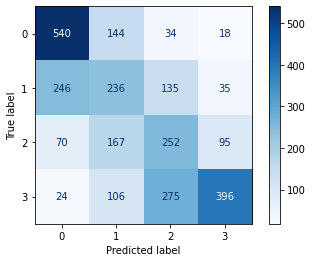

In [59]:
# Display confusion matrix
cm = confusion_matrix(list(y_test), list(y_pred))#,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)#,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

We see a similar result where more mid-categories are being correctly predicted and an overall improvement in f1-score.

In [60]:
df.to_csv('model/NN_multiclass-gridsearch-balanced.csv', index=False)

# Other Classifiers with balanced data

To see if the prediction varies using different models, we also explored logistic regression and SVM.

## 1. Logistic Regression

In [139]:
# Imbalanced training data shape : 2585
# Balanced training data shape : 1988

print(X_train.shape); print(X_test.shape)
print(y_train.shape); print(y_test.shape)

(1988, 5)
(2773, 5)
(1988, 1)
(2773, 1)


In [19]:
logreg = LogisticRegression().fit(X_train, y_train.reshape(-1,))

In [141]:
# Logistic Regression Coeficients
coef = logres.coef_[0]
print (predictors)
print (coef)

['text_cos', 'key', 'title_cos', 'title_ne', 'text_ne']
[ 4.64133342 -0.5365956   3.31912042  0.19176666  0.78393299]


In [142]:
# Prediction on train data
y_pred = logreg.predict(X_train)
print('Accuracy on train data:', logreg.score(X_train, y_train))

# Prediction on test data
y_pred = logreg.predict(X_test)
print('\nTest Report:\nAccuracy on test data:',logreg.score(X_test, y_test))

# Check how far our model has mis-labeled prediction
pred_correct = 0
miss_1_label = 0
miss_2_label = 0
miss_3_label = 0

for pos,i in enumerate(y_test):
    if i-y_pred[pos] == 0:
        pred_correct +=1
    elif abs(i-y_pred[pos]) == 1:
        miss_1_label +=1
    elif abs(i-y_pred[pos]) == 2:
        miss_2_label +=1
    elif abs(i-y_pred[pos]) == 3:
        miss_3_label +=1

print ('\nPrediction correct:', pred_correct*100/len(y_test),'%')
print ('Miss by 1 label:', miss_1_label*100/len(y_test),'%')
print ('Miss by 2 labels:', miss_2_label*100/len(y_test),'%')
print ('Miss by 3 labels:', miss_3_label*100/len(y_test),'%')

Accuracy on train data: 0.5427565392354124

Test Report:
Accuracy on test data: 0.5128020194734945

Prediction correct: 51.28020194734944 %
Miss by 1 label: 37.035701406419044 %
Miss by 2 labels: 9.628561125135233 %
Miss by 3 labels: 2.0555355210962856 %


              precision    recall  f1-score   support

           0       0.58      0.75      0.66       736
           1       0.36      0.30      0.33       652
           2       0.37      0.43      0.40       584
           3       0.69      0.52      0.60       801

    accuracy                           0.51      2773
   macro avg       0.50      0.50      0.50      2773
weighted avg       0.52      0.51      0.51      2773



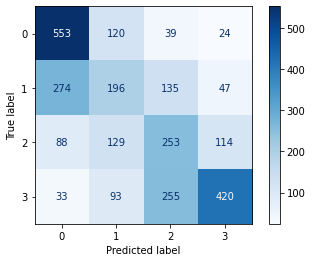

In [143]:
# Classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

## 2. SVM Classifier

In [20]:
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train.reshape(-1,))

Accuracy on train data: 0.545271629778672

Test Report:
Accuracy on test data: 0.5243418680129823
              precision    recall  f1-score   support

           0       0.60      0.75      0.67       736
           1       0.38      0.31      0.35       652
           2       0.38      0.47      0.42       584
           3       0.71      0.53      0.61       801

    accuracy                           0.52      2773
   macro avg       0.52      0.52      0.51      2773
weighted avg       0.53      0.52      0.52      2773



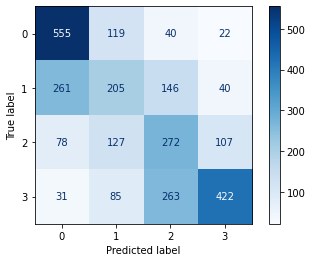

In [109]:
# Prediction on train data
y_pred = clf.predict(X_train)
print('Accuracy on train data:',clf.score(X_train, y_train))

# Prediction on test data
y_pred = clf.predict(X_test)
print('\nTest Report:\nAccuracy on test data:',clf.score(X_test, y_test))

print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

### SVM Classifier - GridSearch

https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/ <div> 
https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/

In [129]:
# Initialize SVM classifier
svm_grid = svm.SVC()

# Tuning hyperparameters
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','poly','rbf','sigmoid']}
 
grid = GridSearchCV(svm_grid, param_grid, refit = True, verbose = 2)
 
# Fitting the model for grid search
svm_grid_result = grid.fit(X_train, y_train.reshape(-1,))

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ......................C=0.1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.0s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=0.1, gamma

[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ........................C=1, gamma=1, kernel=linear; total time=   0.0s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ...................

[CV] END .........................C=10, gamma=1, kernel=poly; total time=   0.0s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   0.0s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   0.0s
[CV] END .........................C=10, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ..........................C=10, gamma=1, kernel=rbf; total time=   0.1s
[CV] END ......................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ......................C=10, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ...................

[CV] END ........................C=100, gamma=1, kernel=poly; total time=   0.4s
[CV] END ........................C=100, gamma=1, kernel=poly; total time=   0.3s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .........................C=100, gamma=1, kernel=rbf; total time=   0.1s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END .....................C=100, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ...................

[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.8s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.7s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.6s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.6s
[CV] END ........................C=1000, gamma=1, kernel=rbf; total time=   0.7s
[CV] END ....................C=1000, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=1000, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=1000, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=1000, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ....................C=1000, gamma=1, kernel=sigmoid; total time=   0.0s
[CV] END ...................C=1000, gamma=0.1, kernel=linear; total time=   0.4s
[CV] END ...................C=1000, gamma=0.1, kernel=linear; total time=   0.4s
[CV] END ...................

In [130]:
# Print search results
print("Best: %f using %s" % (svm_grid_result.best_score_, svm_grid_result.best_params_))

Best: 0.543795 using {'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


In [131]:
# Details in the traininf results
svm_grid_result.cv_results_

{'mean_fit_time': array([0.07679439, 0.07819085, 0.12015615, 0.14326901, 0.07420983,
        0.11019759, 0.15777769, 0.15158811, 0.0764358 , 0.11128173,
        0.16276603, 0.15220027, 0.07878737, 0.11428661, 0.17415586,
        0.15341787, 0.08361406, 0.11249213, 0.16815033, 0.154985  ,
        0.06746264, 0.08018527, 0.10789871, 0.10591893, 0.06636443,
        0.10691481, 0.11728568, 0.11130433, 0.06320381, 0.10850468,
        0.15326533, 0.14421477, 0.06781335, 0.11258216, 0.16875086,
        0.14741058, 0.06465445, 0.10982714, 0.17465305, 0.15111532,
        0.07639594, 0.11608934, 0.11269865, 0.08840499, 0.08198061,
        0.10113473, 0.11727972, 0.10304394, 0.07767386, 0.11592302,
        0.11426969, 0.10731254, 0.07499976, 0.1073822 , 0.14700689,
        0.14181733, 0.07599864, 0.10730577, 0.16744251, 0.16133246,
        0.15965667, 0.44648771, 0.18349257, 0.08058424, 0.13882837,
        0.08277869, 0.11668086, 0.10948257, 0.13662925, 0.10930495,
        0.10672956, 0.09714689,

In [133]:
# Get Hyperparameter listed out and shown as dataframe
means = svm_grid_result.cv_results_['mean_test_score']
stds = svm_grid_result.cv_results_['std_test_score']
params = svm_grid_result.cv_results_['params']

df = pd.DataFrame(params)
df['Mean'] = means
df['Std'] = stds

df.sort_values('Mean',ascending=False)

,C,gamma,kernel,Mean,Std
90,1000.0,0.0100,rbf,0.543795,0.036919
66,100.0,0.1000,rbf,0.541773,0.033805
56,10.0,0.0001,linear,0.541273,0.033815
44,10.0,0.1000,linear,0.541273,0.033815
52,10.0,0.0010,linear,0.541273,0.033815
...,...,...,...,...,...
29,1.0,0.0100,poly,0.260571,0.007489
69,100.0,0.0100,poly,0.260571,0.007489
13,0.1,0.0010,poly,0.260571,0.007489
17,0.1,0.0001,poly,0.260571,0.007489


In [137]:
# Prediction on test data
y_pred = grid.predict(X_test)
print('Accuracy on test data:', grid.score(X_test, y_test))

# Check how far our model has mis-labeled prediction
pred_correct = 0
miss_1_label = 0
miss_2_label = 0
miss_3_label = 0

for pos,i in enumerate(y_test):
    if i-y_pred[pos] == 0:
        pred_correct +=1
    elif abs(i-y_pred[pos]) == 1:
        miss_1_label +=1
    elif abs(i-y_pred[pos]) == 2:
        miss_2_label +=1
    elif abs(i-y_pred[pos]) == 3:
        miss_3_label +=1

print ('\nPrediction correct:', pred_correct*100/len(y_test),'%')
print ('Miss by 1 label:', miss_1_label*100/len(y_test),'%')
print ('Miss by 2 labels:', miss_2_label*100/len(y_test),'%')
print ('Miss by 3 labels:', miss_3_label*100/len(y_test),'%')

Accuracy on test data: 0.5228993869455464

Prediction correct: 52.289938694554635 %
Miss by 1 label: 37.36025964659214 %
Miss by 2 labels: 8.65488640461594 %
Miss by 3 labels: 1.694915254237288 %


              precision    recall  f1-score   support

           0       0.62      0.72      0.67       736
           1       0.38      0.35      0.36       652
           2       0.37      0.47      0.41       584
           3       0.72      0.52      0.61       801

    accuracy                           0.52      2773
   macro avg       0.52      0.51      0.51      2773
weighted avg       0.54      0.52      0.52      2773



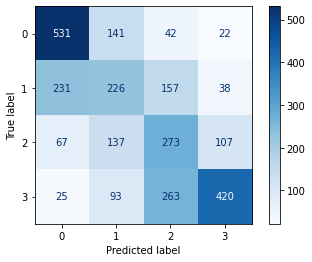

In [138]:
# Classification report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

### Our observation

Overall, the performance is very similar for KerasClassifier, Logistic Regression, and SVM, as the model performs poorly mainly because it misses the label by 1 category, so we conducted another evaluation using a binary classifier in the next notebook.